In [1]:
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Settings,
    ServiceContext,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.embeddings.utils import resolve_embed_model
from llama_index.llms.ollama import Ollama
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core import Settings
from llama_index.core.node_parser.text.sentence import SentenceSplitter

from transformers import AutoTokenizer

import json
import pandas as pd
import random

from llama_cpp import Llama
from llama_cpp import LlamaGrammar

from pathlib import Path

In [2]:
GENERATE_METHODS_DIR = Path('data/docs/manual')
METHODS_DIR = Path('data/docs/methods')
PROMPT_SEEDS_DIR = Path('data/prompts/generation/components')
PROMPT_COMPONENTS_DIR = Path('data/prompts/generation/components')
VAL_PROMPT_COMPONENTS_DIR = Path('data/prompts/validation/components')
GEN_PROMPTS_DIR = Path('data/prompts/generation/output')
VAL_PROMPTS_DIR = Path('data/prompts/validation/output')
PERSIST_DIR = Path("data/persist_dir")
OUTPUT_DIR = Path("output/")
DATASET_PATH = Path('data/datasets/dataset_v3.csv')

# index generation & loading

In [3]:
# default tokenizer is for gpt-3.5
# llama_index.core.global_tokenizer

In [4]:
# documents = SimpleDirectoryReader(METHODS_DIR).load_data()

# embed_tokenizer = AutoTokenizer.from_pretrained(
#     "BAAI/bge-base-en-v1.5"
# )
# Settings.text_splitter = SentenceSplitter(chunk_size=678, tokenizer=embed_tokenizer)

# Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# index = VectorStoreIndex.from_documents(
#     documents, show_progress=True
# )

# index.storage_context.persist(persist_dir=PERSIST_DIR)

In [5]:
Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)

# load index
index = load_index_from_storage(storage_context, show_progress=True)

In [18]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=3,
)

# check index

In [7]:
# Assuming you have an instance of TreeIndex named tree_index
ref_doc_info = index.ref_doc_info

# Now you can iterate over the ref_doc_info to view each node's details
with open('temp/index.txt', 'w') as f:
    for node_id, node_info in ref_doc_info.items():
        f.write(f"Node ID: {node_id}\n")
        f.write(f"Node Info: {node_info}\n")

In [8]:
# r = retriever.retrieve('Get status of a cover.')
# print(r)

# llm loading

In [9]:
llm = Llama('models/mistral-7b-instruct-v0.2.Q6_K.gguf', n_ctx=3000, verbose=False, n_gpu_layers=-1) # mistral-7b-instruct-v0.2.Q4_0.gguf mistral-7b-instruct-v0.2.Q4_K_M.gguf

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 2080, compute capability 7.5, VMM: yes
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from models/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:        

In [10]:
prompt = """
Command: Please, close the living room blinds slowly for 20 seconds.

What is the function user want to call in smart home?
"""
llm.create_chat_completion(messages=[{'role': 'user', 'content': prompt}], max_tokens=100)


llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =      30.34 ms /    78 runs   (    0.39 ms per token,  2571.29 tokens per second)
llama_print_timings: prompt eval time =     106.17 ms /    43 tokens (    2.47 ms per token,   405.00 tokens per second)
llama_print_timings:        eval time =    1320.72 ms /    77 runs   (   17.15 ms per token,    58.30 tokens per second)
llama_print_timings:       total time =    1592.60 ms /   120 tokens


{'id': 'chatcmpl-ccb579d1-43a9-4a63-9185-9bb4f7581452',
 'object': 'chat.completion',
 'created': 1710754907,
 'model': 'models/mistral-7b-instruct-v0.2.Q6_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': ' The user likely wants to invoke a "Close Blinds" or "Close Living Room Blinds" command with an added instruction for the action to be performed slowly and take approximately 20 seconds to complete. In a smart home system, this could be achieved by using voice commands or an app interface that allows users to control their window coverings with adjustable speed settings.'},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 43, 'completion_tokens': 77, 'total_tokens': 120}}

In [11]:
!nvidia-smi

Mon Mar 18 11:41:49 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 22%   28C    P2    61W / 215W |   7670MiB /  8192MiB |     57%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# prompt preparation

In [12]:
json_scheme_prompt = {
    "method": {
        "type": "string"
    },
    "params": {
        "type": "object"
    }
}

example_1_json = {
  "method":"Cover.Open",
  "params":
  {
    "id":2
  }
}

example_2_json = {
  "method":"Cover.Close",
  "params":
  {
    "id":0,
    "duration":5,
  }
}

with open(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md') as f:
  instruction = f.read()

variables = {
    "instruction": instruction,
    "json_scheme": "The output JSON should follow the next scheme: " + json.dumps(json_scheme_prompt),
    "devices": """Cover id=1""",
    "example_1": """Devices: Cover id=2
Methods:
API method 1:
Method name: Cover.Open
Method description:
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Open the cover.
JSON: """ + json.dumps(example_1_json),

    "example_2": """Devices: Cover id=0
Methods: 
API method 1:
Method name: Cover.Close
Method description:
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully close, unless it times out because of maxtime_close first. If duration (seconds) is provided, Cover will move in the close direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Close the kitchen cover quickly (for 5 seconds).
JSON: """ + json.dumps(example_2_json),
}

In [13]:
base_prompt_template = """
{instruction}
{json_scheme}

{example_1}

{example_2}
"""

user_prompt_template = """Devices: {env}
Methods:
{methods_description}
Command: {user_cmd}
JSON:
"""

base_prompt = base_prompt_template.format(**variables)

print(base_prompt)


You are a helpful AI Assistant that controls the devices in a house. For a given user command create a corresponding JSON object. Don't add properties with null value in output JSON object. Output must be strictly in JSON format.
The output JSON should follow the next scheme: {"method": {"type": "string"}, "params": {"type": "object"}}

Devices: Cover id=2
Methods:
API method 1:
Method name: Cover.Open
Method description: Preconditions:
Cover will not accept the command if:
An  overvoltage  error is set at the time of the request.
An  undervoltage  error is set at the time of the request.
An  overtemp  error is set at the time of the request.
An engaged  safety_switch  prohibits movement in the requested direction.
Cover  calibration is running at the time of the request
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it time

# logging

In [14]:
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logger = logging.getLogger()
# logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [15]:
# logger.disabled = True

# JSON generation

In [16]:
with open('data/grammars/json.gbnf') as f:
    grammar_str = f.read()
llama_grammar = LlamaGrammar.from_string(grammar_str)
print(llama_grammar)

from_string grammar:
root ::= object 
object ::= [{] ws object_11 [}] ws 
value ::= object | array | string | number | value_6 ws 
array ::= [[] ws array_15 []] ws 
string ::= ["] string_18 ["] ws 
number ::= number_19 number_25 number_29 ws 
value_6 ::= [t] [r] [u] [e] | [f] [a] [l] [s] [e] | [n] [u] [l] [l] 
ws ::= ws_31 
object_8 ::= string [:] ws value object_10 
object_9 ::= [,] ws string [:] ws value 
object_10 ::= object_9 object_10 | 
object_11 ::= object_8 | 
array_12 ::= value array_14 
array_13 ::= [,] ws value 
array_14 ::= array_13 array_14 | 
array_15 ::= array_12 | 
string_16 ::= [^"\<U+0000>-<U+001F>] | [\] string_17 
string_17 ::= ["\/bfnrt] | [u] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] 
string_18 ::= string_16 string_18 | 
number_19 ::= number_20 number_21 
number_20 ::= [-] | 
number_21 ::= [0-9] | [1-9] number_22 
number_22 ::= [0-9] number_22 | 
number_23 ::= [.] number_24 
number_24 ::= [0-9] number_24 | [0-9] 
number_25 ::= number_23 | 
number_26 ::= [eE

In [21]:
limit_rows = -1 # 20
selected_devices = None # ['Smoke', 'Humidity']

df = pd.read_csv('data/datasets/dataset_v2.csv')
devices = list(df['device'].unique())
if selected_devices:
    df = df[df['device'].isin(selected_devices)].sort_index()
    # print(df)

output_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'mtd', 'json_cmd'])
for i, row in df.iterrows():
    # if i > 50: # or i > 16:
    #     continue
    user_cmd = row['user_cmd']

    device = row['device']
    sample_devices = devices.copy()
    sample_devices.remove(device)
    sample_devices = random.sample(sample_devices, k=2)
    env = f'{sample_devices[0]} id=1, {sample_devices[1]} id=2, {device} id=444'

    retrieval_prompt = "Represent this sentence for searching relevant passages: " + user_cmd
    retrieved_nodes = retriever.retrieve(retrieval_prompt)
    retrieved_nodes = retrieved_nodes[:2]
    methods_names = []
    methods_description = ''
    for k, node in enumerate(retrieved_nodes):
        methods_description += f'API method {k}:\n{node.text}\n\n'
        method_name = node.metadata['file_name'].replace('.md', '')
        methods_names.append(method_name)
    methods_names = ','.join(methods_names)
    methods_description = methods_description.strip('\n')
    

    user_prompt = user_prompt_template.format(**{'env': env, 
                                                 'methods_description': methods_description, 
                                                 'user_cmd': user_cmd})
    llm_prompt = base_prompt + '\n\n' + user_prompt

    try:
        response = llm.create_chat_completion(
            messages=[
                {'role': 'user', 'content': llm_prompt}
            ],
            grammar=llama_grammar
        )
        
        response_text = response['choices'][0]['message']['content']
        response_text = response_text.replace('\_', '_')
        json_cmd = json.dumps(json.loads(response_text))
    except Exception as ex:
        print(response_text)
        print(ex)
        continue

    output_df.loc[len(output_df)] = pd.Series({'id': row['id'], 'device': row['device'], 'user_cmd': user_cmd, 'mtd': methods_names, 'json_cmd': json_cmd})

    # print(user_cmd)
    # print(response_text)

    if limit_rows > 0 and i == limit_rows - 1:
        break

output_num = list(sorted([int(d.name.replace('output', '')) for d in list(OUTPUT_DIR.iterdir())]))[-1] + 1
CUR_OUTPUT_DIR = OUTPUT_DIR / f'output{output_num}'
CUR_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
output_df.to_csv(CUR_OUTPUT_DIR / 'output.csv', index=False, header=True, mode='w')

Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     240.60 ms /    34 runs   (    7.08 ms per token,   141.31 tokens per second)
llama_print_timings: prompt eval time =     710.24 ms /  1137 tokens (    0.62 ms per token,  1600.87 tokens per second)
llama_print_timings:        eval time =     650.41 ms /    33 runs   (   19.71 ms per token,    50.74 tokens per second)
llama_print_timings:       total time =    1705.51 ms /  1170 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     229.55 ms /    33 runs   (    6.96 ms per token,   143.76 tokens per second)
llama_print_timings: prompt eval time =     697.39 ms /  1138 tokens (    0.61 ms per token,  1631.80 tokens per second)
llama_print_timings:        eval time =     630.57 ms /    32 runs   (   19.71 ms per token,    50.75 tokens per second)
llama_print_timings:       to

{"method": "Input.SetConfig", "params": {"id": 444, "config": {"enable": false}}}

Requested tokens (3275) exceed context window of 3000
{"method": "Input.SetConfig", "params": {"id": 444, "config": {"enable": false}}}

Requested tokens (3273) exceed context window of 3000
{"method": "Input.SetConfig", "params": {"id": 444, "config": {"enable": false}}}

Requested tokens (3273) exceed context window of 3000



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     265.93 ms /    37 runs   (    7.19 ms per token,   139.13 tokens per second)
llama_print_timings: prompt eval time =    1015.71 ms /  1625 tokens (    0.63 ms per token,  1599.86 tokens per second)
llama_print_timings:        eval time =     722.96 ms /    36 runs   (   20.08 ms per token,    49.80 tokens per second)
llama_print_timings:       total time =    2117.14 ms /  1661 tokens
Llama.generate: prefix-match hit


{"method": "Input.SetConfig", "params": {"id": 444, "config": {"range_map": [1, 10]}}}
Requested tokens (3275) exceed context window of 3000



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     377.43 ms /    56 runs   (    6.74 ms per token,   148.37 tokens per second)
llama_print_timings: prompt eval time =    1062.41 ms /  1718 tokens (    0.62 ms per token,  1617.08 tokens per second)
llama_print_timings:        eval time =    1123.79 ms /    55 runs   (   20.43 ms per token,    48.94 tokens per second)
llama_print_timings:       total time =    2735.18 ms /  1773 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     149.44 ms /    22 runs   (    6.79 ms per token,   147.22 tokens per second)
llama_print_timings: prompt eval time =    1456.08 ms /  2306 tokens (    0.63 ms per token,  1583.71 tokens per second)
llama_print_timings:        eval time =     439.31 ms /    21 runs   (   20.92 ms per token,    47.80 tokens per second)
llama_print_timings:       total time =    2118.43 ms /  2327 

{"method": "Light.GetConfig", "params": {"id": 444}}

Requested tokens (3233) exceed context window of 3000



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     151.32 ms /    22 runs   (    6.88 ms per token,   145.39 tokens per second)
llama_print_timings: prompt eval time =    1163.50 ms /  1918 tokens (    0.61 ms per token,  1648.47 tokens per second)
llama_print_timings:        eval time =     439.24 ms /    21 runs   (   20.92 ms per token,    47.81 tokens per second)
llama_print_timings:       total time =    1825.24 ms /  1939 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     136.44 ms /    20 runs   (    6.82 ms per token,   146.58 tokens per second)
llama_print_timings: prompt eval time =    1459.33 ms /  2313 tokens (    0.63 ms per token,  1584.98 tokens per second)
llama_print_timings:        eval time =     397.13 ms /    19 runs   (   20.90 ms per token,    47.84 tokens per second)
llama_print_timings:       total time =    2059.53 ms /  2332 

{"method": "Light.GetConfig", "params": {"id": 444}}

Requested tokens (3236) exceed context window of 3000
{"method": "Light.GetConfig", "params": {"id": 444}}

Requested tokens (3083) exceed context window of 3000



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     157.01 ms /    23 runs   (    6.83 ms per token,   146.48 tokens per second)
llama_print_timings: prompt eval time =    1152.12 ms /  1884 tokens (    0.61 ms per token,  1635.24 tokens per second)
llama_print_timings:        eval time =     447.39 ms /    22 runs   (   20.34 ms per token,    49.17 tokens per second)
llama_print_timings:       total time =    1829.79 ms /  1906 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     143.99 ms /    21 runs   (    6.86 ms per token,   145.85 tokens per second)
llama_print_timings: prompt eval time =    1459.31 ms /  2312 tokens (    0.63 ms per token,  1584.31 tokens per second)
llama_print_timings:        eval time =     419.36 ms /    20 runs   (   20.97 ms per token,    47.69 tokens per second)
llama_print_timings:       total time =    2092.76 ms /  2332 

{"method": "Light.GetConfig", "params": {"id": 444, "properties": {"button_presets": {"type": "object"}}
Expecting ',' delimiter: line 1 column 105 (char 104)



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     250.09 ms /    36 runs   (    6.95 ms per token,   143.95 tokens per second)
llama_print_timings: prompt eval time =     736.20 ms /  1206 tokens (    0.61 ms per token,  1638.14 tokens per second)
llama_print_timings:        eval time =     694.60 ms /    35 runs   (   19.85 ms per token,    50.39 tokens per second)
llama_print_timings:       total time =    1791.23 ms /  1241 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     262.51 ms /    38 runs   (    6.91 ms per token,   144.76 tokens per second)
llama_print_timings: prompt eval time =     875.02 ms /  1501 tokens (    0.58 ms per token,  1715.40 tokens per second)
llama_print_timings:        eval time =     742.27 ms /    37 runs   (   20.06 ms per token,    49.85 tokens per second)
llama_print_timings:       total time =    1995.98 ms /  1538 

{"method": "Light.SetConfig", "params": {
"id": 444,
"config": {
"auto
Unterminated string starting at: line 4 column 1 (char 65)



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     145.22 ms /    21 runs   (    6.92 ms per token,   144.61 tokens per second)
llama_print_timings: prompt eval time =    1078.21 ms /  1738 tokens (    0.62 ms per token,  1611.93 tokens per second)
llama_print_timings:        eval time =     412.26 ms /    20 runs   (   20.61 ms per token,    48.51 tokens per second)
llama_print_timings:       total time =    1704.05 ms /  1758 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     145.74 ms /    21 runs   (    6.94 ms per token,   144.09 tokens per second)
llama_print_timings: prompt eval time =     751.97 ms /  1238 tokens (    0.61 ms per token,  1646.34 tokens per second)
llama_print_timings:        eval time =     397.87 ms /    20 runs   (   19.89 ms per token,    50.27 tokens per second)
llama_print_timings:       total time =    1361.97 ms /  1258 

{"method": "Light.GetConfig", "params": {"id": 444, "properties": {"errors": {"type": "object", "description": "An
Unterminated string starting at: line 1 column 112 (char 111)



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     254.23 ms /    37 runs   (    6.87 ms per token,   145.54 tokens per second)
llama_print_timings: prompt eval time =     747.95 ms /  1253 tokens (    0.60 ms per token,  1675.25 tokens per second)
llama_print_timings:        eval time =     718.98 ms /    36 runs   (   19.97 ms per token,    50.07 tokens per second)
llama_print_timings:       total time =    1833.17 ms /  1289 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     213.24 ms /    31 runs   (    6.88 ms per token,   145.38 tokens per second)
llama_print_timings: prompt eval time =    1420.68 ms /  2286 tokens (    0.62 ms per token,  1609.09 tokens per second)
llama_print_timings:        eval time =     630.60 ms /    30 runs   (   21.02 ms per token,    47.57 tokens per second)
llama_print_timings:       total time =    2366.07 ms /  2316 

{"method": "Switch.GetStatus", "params": {"id": 444, "properties": ["pf", "freq"]}}
Requested tokens (3099) exceed context window of 3000



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     757.84 ms /   109 runs   (    6.95 ms per token,   143.83 tokens per second)
llama_print_timings: prompt eval time =     366.75 ms /   521 tokens (    0.70 ms per token,  1420.59 tokens per second)
llama_print_timings:        eval time =    2040.97 ms /   108 runs   (   18.90 ms per token,    52.92 tokens per second)
llama_print_timings:       total time =    3480.11 ms /   629 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     151.72 ms /    22 runs   (    6.90 ms per token,   145.00 tokens per second)
llama_print_timings: prompt eval time =     219.49 ms /   356 tokens (    0.62 ms per token,  1621.93 tokens per second)
llama_print_timings:        eval time =     390.93 ms /    21 runs   (   18.62 ms per token,    53.72 tokens per second)
llama_print_timings:       total time =     825.23 ms /   377 

{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3277) exceed context window of 3000
{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3276) exceed context window of 3000
{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3272) exceed context window of 3000
{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3276) exceed context window of 3000
{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3277) exceed context window of 3000
{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3276) exceed context window of 3000
{"method": "Input.GetConfig", "params": {"id": 444}}
Requested tokens (3276) exceed context window of 3000



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     213.50 ms /    31 runs   (    6.89 ms per token,   145.20 tokens per second)
llama_print_timings: prompt eval time =     487.82 ms /   543 tokens (    0.90 ms per token,  1113.11 tokens per second)
llama_print_timings:        eval time =     567.58 ms /    30 runs   (   18.92 ms per token,    52.86 tokens per second)
llama_print_timings:       total time =    1360.12 ms /   573 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     214.73 ms /    31 runs   (    6.93 ms per token,   144.37 tokens per second)
llama_print_timings: prompt eval time =     919.62 ms /  1540 tokens (    0.60 ms per token,  1674.61 tokens per second)
llama_print_timings:        eval time =     598.94 ms /    30 runs   (   19.96 ms per token,    50.09 tokens per second)
llama_print_timings:       total time =    1831.69 ms /  1570 

{"method": "Light.SetConfig", "params": {
"id": 444,
"config": {
"name": "bedroom curtains",
"in_mode": "dim",
"initial_state": "restore_last",
"min_brightness_on_toggle":
Expecting value: line 7 column 28 (char 171)



llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     164.94 ms /    24 runs   (    6.87 ms per token,   145.51 tokens per second)
llama_print_timings: prompt eval time =     233.77 ms /   380 tokens (    0.62 ms per token,  1625.56 tokens per second)
llama_print_timings:        eval time =     431.34 ms /    23 runs   (   18.75 ms per token,    53.32 tokens per second)
llama_print_timings:       total time =     898.08 ms /   403 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     106.43 ms
llama_print_timings:      sample time =     211.99 ms /    31 runs   (    6.84 ms per token,   146.23 tokens per second)
llama_print_timings: prompt eval time =     266.12 ms /   467 tokens (    0.57 ms per token,  1754.83 tokens per second)
llama_print_timings:        eval time =     565.16 ms /    30 runs   (   18.84 ms per token,    53.08 tokens per second)
llama_print_timings:       total time =    1131.21 ms /   497 

In [29]:
output_df.tail()

,id,device,user_cmd,mtd,json_cmd
192,192,Temperature,Could you lower the temperature to 18 degrees ...,Temperature.SetTemperature,"{""method"": ""Temperature.SetTemperature"", ""para..."
193,193,Temperature,Set the temperature to 20 degrees in the bedroom.,Temperature.SetTemperature,"{""method"": ""Temperature.SetTemperature"", ""para..."
194,194,Humidity,Can you increase the humidity in the living ro...,Humidity.SetHumidity,"{""method"": ""Humidity.SetHumidity"", ""params"": {..."
195,195,Humidity,Set the humidity to 50% in the bedroom.,Humidity.SetHumidity,"{""method"": ""Humidity.SetHumidity"", ""params"": {..."
196,196,Humidity,Decrease the humidity in the kitchen to 40 per...,Humidity.SetHumidity,"{""method"": ""Humidity.SetHumidity"", ""params"": {..."


# evaluation

In [3]:
def check_additional_parameters(gt_json, pred_json):
    if len(set(pred_json.keys()) - set(gt_json.keys())) > 0:
        return True
    for key, val in gt_json.items():
        if key not in pred_json:
            continue
        if type(val) == dict:
            if check_additional_parameters(val, pred_json[key]):
                return True
    return False

def check_incorrect_parameters(gt_json, pred_json):
    for key, val in gt_json.items():
        if key not in pred_json:
            return True
        if type(val) == dict:
            if check_incorrect_parameters(val, pred_json[key]):
                return True
        elif pred_json[key] != val:
            return True
    return False

In [4]:
df = pd.read_csv(DATASET_PATH)
CUR_OUTPUT_DIR = Path('output/output4')
output_df = pd.read_csv(CUR_OUTPUT_DIR / 'output.csv')
merged_df = df.merge(output_df, how='inner', on='id', suffixes=("_gt", "_pred"))

compared_output_df = pd.DataFrame(columns=['device', 'user_cmd', 'gt_mtd', 'pred_mtd', 'gt_json_cmd', 'pred_json_cmd', 'method', 'add_params', 'inc_params'])
for _, row in merged_df.iterrows():
    correct_ouput = True
    methods_names_pred = row['mtd_pred'].split(',')
    try:
        gt_json = json.loads(row['json_cmd_gt'])
        pred_json = json.loads(row['json_cmd_pred'])
    except Exception as ex:
        print(ex)
        print(row['id'])
        print(row['json_cmd_gt'])
        print(row['json_cmd_pred'])
        continue
    compared_dict = {'device': row['device_gt'],
        'user_cmd': row['user_cmd_gt'], 'gt_mtd': row['mtd_gt'],
        'pred_mtd': row['mtd_pred'], 'gt_json_cmd': row['json_cmd_gt'], 'pred_json_cmd': row['json_cmd_pred']}
    
    compared_dict['method'] = row['mtd_gt'] in methods_names_pred
    compared_dict['add_params'] = check_additional_parameters(gt_json, pred_json)
    compared_dict['inc_params'] = check_incorrect_parameters(gt_json, pred_json)

    compared_output_df.loc[len(compared_output_df)] = pd.Series(compared_dict)

compared_output_df.to_csv(CUR_OUTPUT_DIR / 'compared_output.csv', index=False)

print(len(df))
print(len(merged_df))

194
175


For incorrect retrieved method we mostly have incorrect parameters. Don't need to inspect them further until we fix incorrect parameters.

Excluding samples with incorrectly retrieved method, part of samples with additional parameters is relatively small and higher for methods with incorrect parameters.

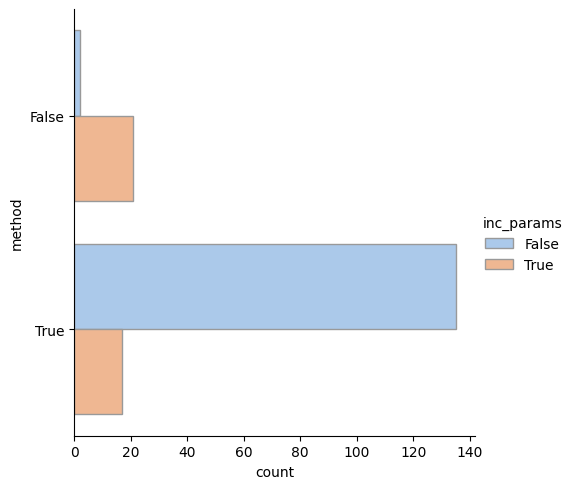

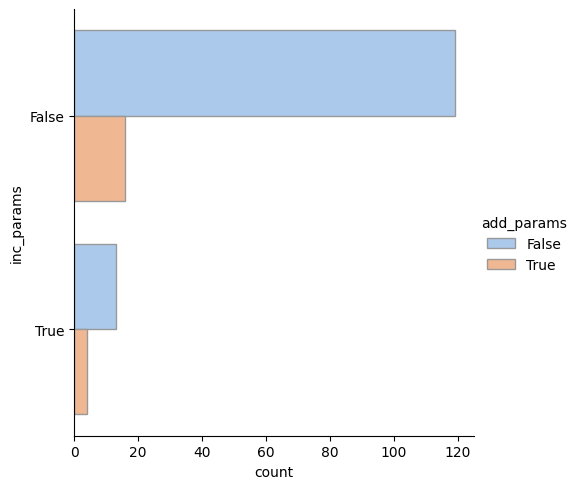

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df = compared_output_df

sns.catplot(
    data=df, y="method", hue="inc_params", kind="count",
    palette="pastel", edgecolor=".6",
)
plt.show()

sns.catplot(
    data=df[df['method'] == True], y="inc_params", hue="add_params", kind="count",
    palette="pastel", edgecolor=".6",
)
plt.show()